### Empiezo a desarrollar el sistema de recomiendación

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fastapi import FastAPI
from pydantic import BaseModel
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
df_movies =  pd.read_csv("df_movies_reducido.csv")
df_movies

,id,title,genres_names,release_date,budget,revenue,runtime,vote_average,vote_count,production_companies_names,original_language,release_year
0,27205,Inception,"['Action', 'Thriller', 'Science Fiction', 'Mys...",2010-07-14,160000000.0,8.255328e+08,148.0,8.1,14075.0,"['Legendary Pictures', 'Warner Bros.', 'Syncopy']",en,2010
1,155,The Dark Knight,"['Drama', 'Action', 'Crime', 'Thriller']",2008-07-16,185000000.0,1.004558e+09,152.0,8.3,12269.0,"['DC Comics', 'Legendary Pictures', 'Warner Br...",en,2008
2,19995,Avatar,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",2009-12-10,237000000.0,2.787965e+09,162.0,7.2,12114.0,"['Ingenious Film Partners', 'Twentieth Century...",en,2009
3,24428,The Avengers,"['Science Fiction', 'Action', 'Adventure']",2012-04-25,220000000.0,1.519558e+09,143.0,7.4,12000.0,"['Paramount Pictures', 'Marvel Studios']",en,2012
4,293660,Deadpool,"['Action', 'Adventure', 'Comedy']",2016-02-09,58000000.0,7.831130e+08,108.0,7.4,11444.0,"['Twentieth Century Fox Film Corporation', 'Ma...",en,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
34995,60457,Michael Jordan: An American Hero,['Drama'],1999-04-18,0.0,0.000000e+00,0.0,5.2,3.0,[],en,1999
34996,23331,Planet Outlaws,['Science Fiction'],1953-01-01,0.0,0.000000e+00,71.0,4.7,3.0,[],en,1953
34997,105073,The Shadow Strikes,['Mystery'],1937-10-29,0.0,0.000000e+00,62.0,3.7,3.0,['Colony Pictures'],en,1937
34998,85827,Island of the Blue Dolphins,"['Family', 'Drama']",1964-09-10,0.0,0.000000e+00,93.0,5.7,3.0,"['Universal Pictures', 'Robert B. Radnitz Prod...",en,1964


In [7]:
df_credits =  pd.read_csv("df_credits_reducido.csv")
df_credits

,id,cast_procesado,crew_procesado
0,469172,"[{'nombre': 'Ruben de Freitas', 'personaje': '...","[{'nombre': 'Paulo Branco', 'trabajo': 'Produc..."
1,468707,"[{'nombre': 'Inka Haapamäki', 'personaje': 'Sa...","[{'nombre': 'Hannaleena Hauru', 'trabajo': 'Di..."
2,468343,[],"[{'nombre': 'Jack Witikka', 'trabajo': 'Direct..."
3,467731,"[{'nombre': 'Lloyd Bridges', 'personaje': 'Ale...","[{'nombre': 'Sidney Lumet', 'trabajo': 'Direct..."
4,465044,"[{'nombre': 'Karolina Antosik', 'personaje': '...","[{'nombre': 'Molly Smith', 'trabajo': 'Directo..."
...,...,...,...
34995,24130,"[{'nombre': 'James Coburn', 'personaje': 'Dere...","[{'nombre': 'Jerry Goldsmith', 'trabajo': 'Ori..."
34996,24129,"[{'nombre': 'Stellan Skarsgård', 'personaje': ...","[{'nombre': 'Jan Persson', 'trabajo': 'Editor'..."
34997,24128,"[{'nombre': 'David Byrne', 'personaje': 'Vocal...","[{'nombre': 'Jonathan Demme', 'trabajo': 'Dire..."
34998,24126,"[{'nombre': 'Julian Sands', 'personaje': 'Warl...","[{'nombre': 'David Twohy', 'trabajo': 'Writer'..."


## Análisis de sentimientos
Divide el rango de la columna vote_average en intervalos específicos, definidos en bins.
bins=[0, 5, 7, 10] define tres intervalos:

0 a 5: Categoría Negativo

5 a 7: Categoría Neutral

7 a 10: Categoría Positivo

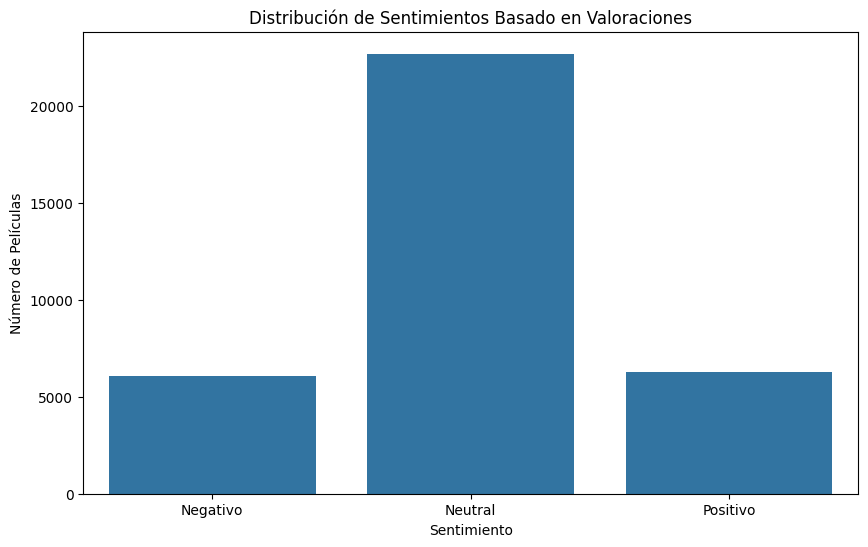

Distribución de sentimientos (%):
sentimiento
Neutral     64.8
Positivo    17.9
Negativo    17.3
Name: proportion, dtype: float64
Estadísticas de valoraciones:
Promedio: 6.05
Mediana: 6.2


In [8]:
# Crear categorías de sentimiento en base a la valoración promedio
df_movies['sentimiento'] = pd.cut(df_movies['vote_average'], 
                                  bins=[0, 5, 7, 10],
                                  labels=['Negativo', 'Neutral', 'Positivo'])

# Crear gráfico de barras para visualizar la distribución de sentimientos
plt.figure(figsize=(10, 6))
sns.countplot(data=df_movies, x='sentimiento')
plt.title('Distribución de Sentimientos Basado en Valoraciones')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Películas')
plt.show()

# Calcular y mostrar la distribución de sentimientos en porcentaje
print("Distribución de sentimientos (%):")
print(df_movies['sentimiento'].value_counts(normalize=True).round(3) * 100)

# Calcular y mostrar estadísticas básicas de las valoraciones
print("Estadísticas de valoraciones:")
print("Promedio:", round(df_movies['vote_average'].mean(), 2))
print("Mediana:", round(df_movies['vote_average'].median(), 2))


In [9]:
import pandas as pd

# Verificar las columnas para identificar la clave común
print("Columnas de df_movies:", df_movies.columns)
print("Columnas de df_credits:", df_credits.columns)

# Realizar el merge usando la columna en común (ajusta el nombre si es diferente)
df_merged = pd.merge(df_movies, df_credits, on='id', how='inner')  # usa 'id' o la columna correspondiente

# Guardar el resultado en un archivo CSV
df_merged.to_csv('df_combinado.csv', index=False)


Columnas de df_movies: Index(['id', 'title', 'genres_names', 'release_date', 'budget', 'revenue',
       'runtime', 'vote_average', 'vote_count', 'production_companies_names',
       'original_language', 'release_year', 'sentimiento'],
      dtype='object')
Columnas de df_credits: Index(['id', 'cast_procesado', 'crew_procesado'], dtype='object')


In [10]:
df =  pd.read_csv("df_combinado.csv")
df

,id,title,genres_names,release_date,budget,revenue,runtime,vote_average,vote_count,production_companies_names,original_language,release_year,sentimiento,cast_procesado,crew_procesado
0,27205,Inception,"['Action', 'Thriller', 'Science Fiction', 'Mys...",2010-07-14,160000000.0,8.255328e+08,148.0,8.1,14075.0,"['Legendary Pictures', 'Warner Bros.', 'Syncopy']",en,2010,Positivo,"[{'nombre': 'Leonardo DiCaprio', 'personaje': ...","[{'nombre': 'Hans Zimmer', 'trabajo': 'Origina..."
1,24428,The Avengers,"['Science Fiction', 'Action', 'Adventure']",2012-04-25,220000000.0,1.519558e+09,143.0,7.4,12000.0,"['Paramount Pictures', 'Marvel Studios']",en,2012,Positivo,"[{'nombre': 'Robert Downey Jr.', 'personaje': ...","[{'nombre': 'Alan Silvestri', 'trabajo': 'Orig..."
2,293660,Deadpool,"['Action', 'Adventure', 'Comedy']",2016-02-09,58000000.0,7.831130e+08,108.0,7.4,11444.0,"['Twentieth Century Fox Film Corporation', 'Ma...",en,2016,Positivo,"[{'nombre': 'Ryan Reynolds', 'personaje': 'Wad...","[{'nombre': 'Robert Alonzo', 'trabajo': 'Stunt..."
3,157336,Interstellar,"['Adventure', 'Drama', 'Science Fiction']",2014-11-05,165000000.0,6.751200e+08,169.0,8.1,11187.0,"['Paramount Pictures', 'Legendary Pictures', '...",en,2014,Positivo,"[{'nombre': 'Matthew McConaughey', 'personaje'...","[{'nombre': 'Kendelle Elliott', 'trabajo': 'Ar..."
4,68718,Django Unchained,"['Drama', 'Western']",2012-12-25,100000000.0,4.253682e+08,165.0,7.8,10297.0,"['Columbia Pictures', 'The Weinstein Company']",en,2012,Positivo,"[{'nombre': 'Jamie Foxx', 'personaje': 'Django...","[{'nombre': 'Robert Rodriguez', 'trabajo': 'Th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24873,29054,Black Scorpion II: Aftershock,"['Comedy', 'Action', 'Adventure', 'Science Fic...",1997-05-13,0.0,0.000000e+00,85.0,5.7,3.0,['Concorde-New Horizons'],en,1997,Neutral,"[{'nombre': 'Joan Severance', 'personaje': 'Da...","[{'nombre': 'Roger Corman', 'trabajo': 'Execut..."
24874,60457,Michael Jordan: An American Hero,['Drama'],1999-04-18,0.0,0.000000e+00,0.0,5.2,3.0,[],en,1999,Neutral,"[{'nombre': 'Michael Jace', 'personaje': 'Mich...","[{'nombre': 'Alan Metzger', 'trabajo': 'Direct..."
24875,105073,The Shadow Strikes,['Mystery'],1937-10-29,0.0,0.000000e+00,62.0,3.7,3.0,['Colony Pictures'],en,1937,Negativo,"[{'nombre': 'Rod La Rocque', 'personaje': 'Lam...","[{'nombre': 'Lynn Shores', 'trabajo': 'Directo..."
24876,85827,Island of the Blue Dolphins,"['Family', 'Drama']",1964-09-10,0.0,0.000000e+00,93.0,5.7,3.0,"['Universal Pictures', 'Robert B. Radnitz Prod...",en,1964,Neutral,"[{'nombre': 'Celia Kaye', 'personaje': 'Karana...","[{'nombre': 'James B. Clark', 'trabajo': 'Dire..."


In [11]:
# Voy a calcular la similitud de coseno usando las características relevantes
from sklearn.feature_extraction.text import TfidfVectorizer

# Utilizo el vectorizador TF-IDF para convertir texto en vectores numéricos
vectorizer = TfidfVectorizer()

# Concatenamos las características de texto que queremos usar para la similitud
# Voy a usar las columnas 'genres_names', 'cast_procesado', y 'crew_procesado'
df['combined_features'] = df['genres_names'] + ' ' + df['cast_procesado'] + ' ' + df['crew_procesado']

# Convierto las características combinadas en una matriz TF-IDF
feature_matrix = vectorizer.fit_transform(df['combined_features'])

# Calculo la similitud de coseno
cosine_sim = cosine_similarity(feature_matrix)

# La matriz de similitud de coseno
print("Matriz de similitud de coseno:")
print(cosine_sim)

Matriz de similitud de coseno:
[[1.         0.34451136 0.34485618 ... 0.26907407 0.28924422 0.15487427]
 [0.34451136 1.         0.72381654 ... 0.30685362 0.35090646 0.16667147]
 [0.34485618 0.72381654 1.         ... 0.31118045 0.36794068 0.16803862]
 ...
 [0.26907407 0.30685362 0.31118045 ... 1.         0.27184104 0.15768791]
 [0.28924422 0.35090646 0.36794068 ... 0.27184104 1.         0.13041277]
 [0.15487427 0.16667147 0.16803862 ... 0.15768791 0.13041277 1.        ]]
